In [1]:
import xarray as xr
import numpy as np
from scipy import stats
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pathlib import Path
import datetime
from string import ascii_lowercase, ascii_uppercase


In [2]:
# https://wiki.mpimet.mpg.de/doku.php?id=analysis:pot_pourri:statistics:controlling_fdr
def xr_multipletest(p, alpha=0.05, method="fdr_bh", **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests

    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

# https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/
def fdr_threshold(pvalues, alpha=0.05):
    """Computes the FDR threshod after Wilks (2016)."""
    pvalues_flat = np.asarray(pvalues).flatten()
    pvalues_filt = pvalues_flat[~np.isnan(pvalues_flat)]
    p = np.sort(pvalues_filt)
    n = len(p)
    return np.max(np.where(p <= (np.arange(1, n+1) / n * alpha), p, 0)), p


In [3]:
xr.set_options(keep_attrs=True)
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update({"font.size": 22})

In [4]:
diff_hl_pv = xr.open_dataarray('diff_hl_pvalues.nc')

In [5]:
diff_ll_pv = xr.open_dataarray('diff_ll_pvalues.nc')

In [6]:
diff_hl_pv_fdr = xr.open_dataarray('diff_hl_pvalues_FDR.nc')

In [7]:
diff_ll_pv_fdr = xr.open_dataarray('diff_ll_pvalues_FDR.nc')

In [8]:
tpp_ll = xr.open_dataarray('tpp_ll.nc')
tpp_hl = xr.open_dataarray('tpp_hl.nc')
tpp_pl = xr.open_dataarray('tpp_pl.nc')

In [9]:
diff_hl = xr.open_dataarray('diff_hl.nc')
diff_ll = xr.open_dataarray('diff_ll.nc')

In [10]:
ds_diff = xr.load_dataset('../../ehf_diff.nc')
ds_diff


<xarray.Dataset> Size: 64kB
Dimensions:  (time: 151, plev: 26)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2023-01-01 2023-01-02 ... 2023-05-31
    lon      float64 8B 0.0
  * plev     (plev) float64 208B 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Data variables:
    ehf      (time, plev) float64 31kB -5.756 6.191 17.36 ... 0.6946 0.7566
    pv       (time, plev) float64 31kB 0.6409 0.6729 0.3235 ... 0.4853 0.39
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48

In [11]:
nam_wo = xr.open_dataset('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt2-all_NAM_2021-2025.nc')['nam']
nam_w = xr.open_dataset('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt1-all_NAM_2021-2025.nc')['nam']

In [98]:
diff.isnull()

<xarray.DataArray 'nam' (time: 1461, plev: 47)> Size: 69kB
array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True]])
Coordinates:
  * time     (time) datetime64[ns] 12kB 2022-01-01 2022-01-02 ... 2025-12-31
  * plev     (plev) float64 376B 0.009946 0.04281 0.1112 ... 995.4 1.009e+03

In [12]:
diff = nam_w.mean("ens") - nam_wo.mean("ens")
t_stat, p_values = stats.ttest_ind(nam_w, nam_wo, equal_var=False, nan_policy='omit')
diff_pv = xr.DataArray(p_values, coords=diff.coords)
diff_pv_fdr = xr_multipletest(diff_pv)[1]

## In 2023

TE+NAM+EHF_time-evolution_2023-JFMA_FIG2_new.pdf


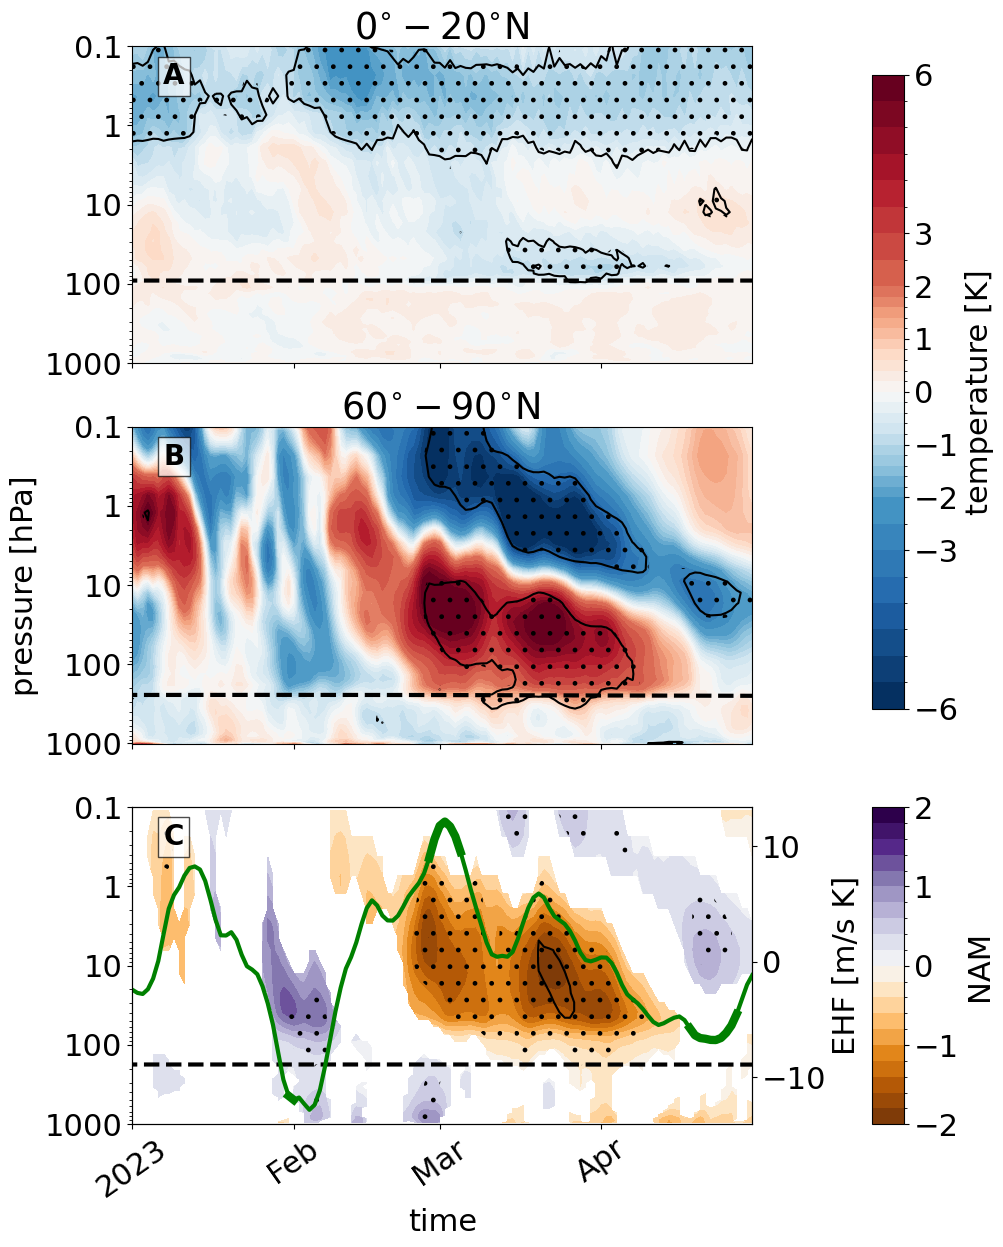

In [93]:
time_slice= slice("2022-12-31", "2023-04")
sel_dict = dict(time=time_slice, plev = slice(0.1,None))


f, axes = plt.subplots(3, 1, figsize=(8, 14), sharex=True)

levels = np.linspace(-4,4,21)
levels = np.arange(-6,-2,0.5).tolist()+np.arange(-2,2,0.2).tolist()+np.arange(2,6.5,0.5).tolist()

p =  diff_ll.plot.contourf(
    x = 'time', yincrease = False, robust = True, levels = levels, 
    add_colorbar=False, ax = axes[0]
)

diff_hl.plot.contourf(
    x = 'time', yincrease = False, robust = True, levels = levels, 
    add_colorbar=False, ax = axes[1]
)

p2 = diff.sel(**sel_dict).where(diff_pv < 0.32).plot.contourf(
    x="time", yincrease=False, levels=21, cmap="PuOr",
    #cbar_kwargs = cbar_kwargs, extend = 'both',
    add_colorbar = False,
    ax = axes[2],
    vmax = 2,
)


kwargs = dict(
    yincrease= False,
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.05],
    colors="none",
    hatches=[
        ".", #"//",
        None,
    ],
    # linewidths=np.linspace(1, 4, 4),
)
diff_ll_pv.plot.contourf(x="time", ax=axes[0], **kwargs)
diff_hl_pv.plot.contourf(x="time", ax=axes[1], **kwargs)
diff_pv.sel(**sel_dict).plot.contourf(x="time", ax=axes[2], **kwargs)

kwargs = dict(
    yincrease= False,
    # colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],
    colors="none",
    hatches=[
        ".",
        None,
    ],
    # linewidths=np.linspace(1, 4, 4),
)
#diff_ll_pv.plot.contourf(x="time", ax=axes[0], **kwargs)
#diff_hl_pv.plot.contourf(x="time", ax=axes[1], **kwargs)
#diff_pv.sel(**sel_dict).plot.contourf(x="time", ax=axes[2], **kwargs)

kwargs = dict(
    yincrease= False,
    colors=("orange"),
    add_colorbar=False,
    levels=[0, 0.32],
)

#diff_ll_pv_fdr.plot.contour(x="time", ax=axes[0], **kwargs)
#diff_hl_pv_fdr.plot.contour(x="time", ax=axes[1], **kwargs)
#diff_pv.sel(**sel_dict).plot.contour(x="time", ax=axes[2], **kwargs)

kwargs = dict(
    yincrease= False,
    colors=("k"),
    add_colorbar=False,
    levels=[0, 0.32],
)

diff_ll_pv_fdr.plot.contour(x="time", ax=axes[0], **kwargs)
diff_hl_pv_fdr.plot.contour(x="time", ax=axes[1], **kwargs)
diff_pv_fdr.sel(**sel_dict).plot.contour(x="time", ax=axes[2], **kwargs)

tpp_ll.plot(ax = axes[0], color="k", lw=3, ls = "--")
tpp_hl.plot(ax = axes[1], color="k", lw=3, ls = "--")
tpp_pl.plot(ax = axes[2], color="k", lw=3, ls = "--")


axes[0].set_title(r'0$^{\circ}-$20$^{\circ}$N')
axes[1].set_title(r'60$^{\circ}-$90$^{\circ}$N ')


for i,ax in enumerate(axes):
    ax.set_yscale('log')
    ax.set_ylim(None,0.1)

    if i != 2:
        ax.set_xlabel('')

    if i != 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('pressure [hPa]')

    label = ascii_uppercase[i]
    ax.text(
            0.05,
            0.95,
            label,
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="top",
            bbox={"alpha": 0.7, "facecolor": "white"},
        )

    
    
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 4, 30)])
    
    

    

ax2 = ax.twinx()
temp = ds_diff.sel(plev = 100, method='nearest').sel(time = time_slice)
temp['ehf'].plot(ax = ax2, color = 'green', lw = 3)
temp['ehf'].where(temp['pv'] < 0.05).plot(ax = ax2, color = 'green', lw = 6)

ax2.set_title('')
ax2.set_ylabel('EHF [m/s K]')

X = ax.xaxis
X.set_major_locator(mdates.MonthLocator())#locator_daily)
#X.set_major_formatter(fmt)
X.set_tick_params(rotation=35)

posn = axes[1].get_position()
cax = f.add_axes([0.1,-0.1,0.5,0.1])
cx_shift= 0.15
cax.set_position([posn.x0+posn.width+cx_shift, posn.y0+0.025, 0.04, posn.height*2])
f.colorbar(p, cax=cax, orientation='vertical', label='temperature [K]', extend = 'both', spacing = 'proportional', ticks = [-6,-3,-2,-1,0,1,2,3,6])

posn = axes[2].get_position()
cax = f.add_axes([0.1,-0.1,0.5,0.1])
cax.set_position([posn.x0+posn.width+cx_shift, posn.y0+0.0, 0.04, posn.height])
f.colorbar(p2, cax=cax, orientation='vertical', label='NAM', extend = 'both', spacing = 'proportional', ticks = [-6,-3,-2,-1,0,1,2,3,6])

outfile = f"TE+NAM+EHF_time-evolution_2023-JFMA_FIG2_new.pdf"
print(outfile)
plt.savefig(outfile, bbox_inches="tight")